In [1]:
import torch
import cv2
import os
from autocrop_kh import autocrop

img_path = "example.jpg"
model_path = "autocrop_model_v2.onnx"


if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image file {img_path} was not found.")
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file {model_path} was not found.")

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

extracted_document = autocrop(
    img_path=img_path,
    model_path=model_path, 
    device=device)


output_path = "extracted_document.jpg"
cv2.imwrite(output_path, extracted_document[:, :, ::-1])  # Convert back to BGR for saving
print(f"Extracted document saved to {output_path}")


Extracted document saved to extracted_document.jpg


In [ ]:

from openai import OpenAI
import os
import base64
import json
import cv2
import numpy as np
from PIL import Image
import requests
from io import BytesIO
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

# Get image dimensions first
image_path = "C:/Users/smmeh/Desktop/Project Doc Reader/extracted_document.jpg"
img = cv2.imread(image_path)
height, width = img.shape[:2]

print(f"Image dimensions: {width}x{height}")

# Improved prompt - request normalized coordinates then convert ourselves
prompt = f"""Analyze this image and detect all text elements with their bounding boxes. 

Return results in strict JSON format:
{{
  "text_elements": [
    {{
      "text": "detected text content",
      "bbox": [x1, y1, x2, y2],
      "confidence": 0.95
    }}
  ]
}}

CRITICAL REQUIREMENTS:
- bbox must be in NORMALIZED coordinates (0.0 to 1.0 range) as fractions of image dimensions
- Format: [left, top, right, bottom] where each value is between 0.0 and 1.0
- x1 < x2 and y1 < y2
- Include all visible text including Persian/Arabic text
- Confidence is between 0 and 1

Return ONLY valid JSON, no explanation.

Image dimensions for reference: {width}x{height} pixels"""

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key="..",
)

base64_image = encode_image(image_path)

completion = client.chat.completions.create(
    extra_headers={
        "HTTP-Referer": "http://localhost:3000", 
        "X-Title": "Document Reader", 
    },
    model="qwen/qwen3-vl-235b-a22b-instruct",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                }
            ]
        }
    ]
)

# Get the response
response = completion.choices[0].message.content
print("Raw response:", response)


Image dimensions: 650x954
Raw response: {
  "text_elements": [
    {
      "text": "DR.BABAEI",
      "bbox": [0.049, 0.088, 0.163, 0.104],
      "confidence": 0.95
    },
    {
      "text": "SONOGRAPHY & RADIOLOGY",
      "bbox": [0.049, 0.104, 0.163, 0.111],
      "confidence": 0.95
    },
    {
      "text": "کلینیک رادیولوژی و سونوگرافی",
      "bbox": [0.632, 0.069, 0.901, 0.093],
      "confidence": 0.95
    },
    {
      "text": "دکتر فاطمه بابایی",
      "bbox": [0.685, 0.093, 0.848, 0.115],
      "confidence": 0.95
    },
    {
      "text": "نام بیمار : خانم زهرا سادات برهمند",
      "bbox": [0.595, 0.188, 0.928, 0.212],
      "confidence": 0.95
    },
    {
      "text": "سن : ۲۴ سال",
      "bbox": [0.378, 0.188, 0.511, 0.212],
      "confidence": 0.95
    },
    {
      "text": "تاریخ : ۱۴۰۴/۰۶/۰۸",
      "bbox": [0.155, 0.188, 0.318, 0.212],
      "confidence": 0.95
    },
    {
      "text": "همکار گرامی دکتر خانم سرکار قریبی",
      "bbox": [0.529, 0.226, 0.918, 0.256

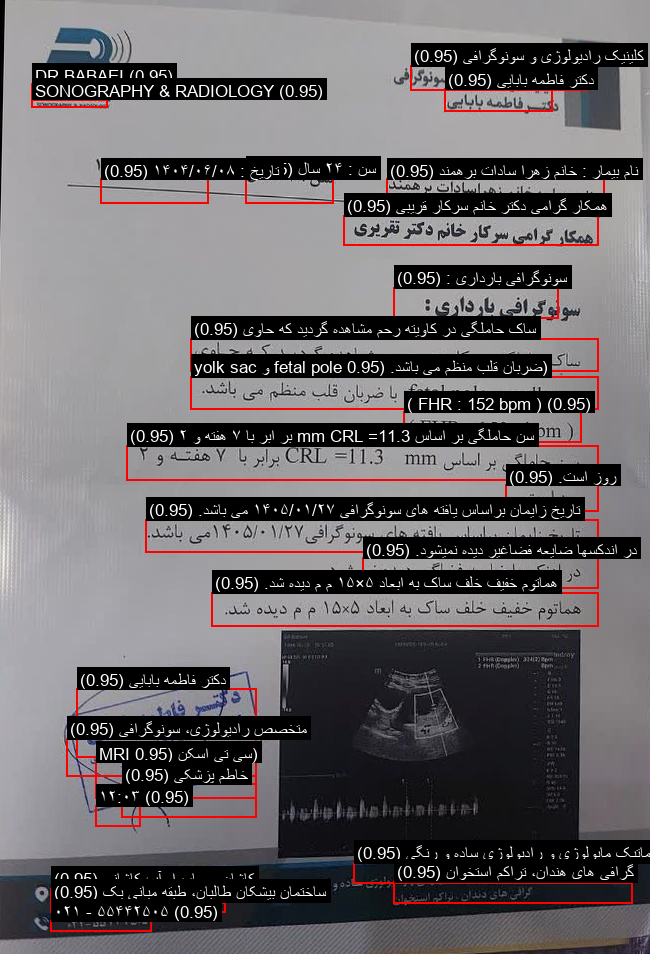

Saved visualization to: extracted_document_vis.jpg


In [10]:
# Jupyter-friendly visualization of normalized bboxes (drop this whole cell into a notebook)
import json
import os
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from IPython.display import display
import cv2

def visualize_bboxes_notebook(image_path, model_response, show_inline=True, out_path=None,
                              min_font_ratio=0.018, thickness_ratio=0.0025,
                              try_arabic_reshaper=True):
    """
    Visualize normalized bounding boxes (0..1) returned by model on an image and display inline.
    
    Parameters
    - image_path: path to image file
    - model_response: JSON string OR dict with {"text_elements":[{"text":"...","bbox":[x1,y1,x2,y2],"confidence":0.95}, ...]}
    - show_inline: if True, display image inline in the notebook
    - out_path: optional path to save visualized image; if None saves next to input image with suffix '_vis'
    - min_font_ratio: fraction of image height to choose font size
    - thickness_ratio: fraction of min(width,height) to compute rectangle thickness
    - try_arabic_reshaper: if True, try to import arabic_reshaper and bidi.algorithm.get_display for better Persian/Arabic rendering
    """
    # Parse response
    if isinstance(model_response, str):
        resp = json.loads(model_response)
    else:
        resp = model_response

    # Load image via PIL
    pil_img = Image.open(image_path).convert("RGB")
    width, height = pil_img.size
    draw = ImageDraw.Draw(pil_img)

    # Try to enable better Arabic/Persian shaping if libs available
    use_reshaper = False
    reshaper = None
    get_display = None
    if try_arabic_reshaper:
        try:
            import arabic_reshaper
            from bidi.algorithm import get_display
            reshaper = arabic_reshaper
            use_reshaper = True
        except Exception:
            use_reshaper = False

    # Choose font (try to pick a font that supports Arabic/Persian shaping)
    font_size = max(int(height * min_font_ratio), 12)
    preferred_fonts = [
        "arial.ttf"
    ]
    font = None
    for fpath in preferred_fonts:
        try:
            font = ImageFont.truetype(fpath, font_size)
            break
        except Exception:
            font = None
    if font is None:
        font = ImageFont.load_default()
    # Box/label appearance
    rect_color = (255, 0, 0)          # red
    label_text_color = (255, 255, 255)
    label_bg_color = (0, 0, 0)        # black (opaque)
    thickness = max(1, int(round(min(width, height) * thickness_ratio)))

    items = resp.get("text_elements", [])
    for item in items:
        try:
            text = item.get("text", "")
            conf = float(item.get("confidence", 0.0))
            bbox = item.get("bbox", None)
            if bbox is None or len(bbox) != 4:
                continue

            # Normalize & clip to [0,1]
            x1 = min(max(float(bbox[0]), 0.0), 1.0)
            y1 = min(max(float(bbox[1]), 0.0), 1.0)
            x2 = min(max(float(bbox[2]), 0.0), 1.0)
            y2 = min(max(float(bbox[3]), 0.0), 1.0)
            left = min(x1, x2); right = max(x1, x2)
            top = min(y1, y2); bottom = max(y1, y2)

            # Convert to pixel coords
            px1 = int(round(left * width))
            py1 = int(round(top * height))
            px2 = int(round(right * width))
            py2 = int(round(bottom * height))

            # Draw rectangle (thickness handled by drawing multiple rectangles)
            for t in range(thickness):
                draw.rectangle([px1 - t, py1 - t, px2 + t, py2 + t], outline=rect_color)

            # Prepare label string
            label = f"{text} ({conf:.2f})"

            # Apply Arabic reshaping & bidi if available and text likely Arabic/Persian
            if use_reshaper:
                try:
                    # only reshape if characters in Arabic/Persian unicode range
                    if any('\u0600' <= ch <= '\u06FF' for ch in label):
                        label = get_display(reshaper.reshape(label))
                except Exception:
                    pass

            # Determine text size
            # PIL.ImageDraw.textbbox is available in modern Pillow; fall back to textsize
            try:
                bbox_text = draw.textbbox((0,0), label, font=font)
                text_w = bbox_text[2] - bbox_text[0]
                text_h = bbox_text[3] - bbox_text[1]
            except Exception:
                text_w, text_h = draw.textsize(label, font=font)

            padding = max(3, int(font_size * 0.15))

            # Label background: try above bbox, else below
            bg_left = px1
            bg_top = py1 - text_h - 2 * padding
            bg_right = px1 + text_w + 2 * padding
            bg_bottom = py1

            if bg_top < 0:
                bg_top = py2
                bg_bottom = py2 + text_h + 2 * padding

            draw.rectangle([bg_left, bg_top, bg_right, bg_bottom], fill=label_bg_color)
            text_x = bg_left + padding
            text_y = bg_top + padding

            draw.text((text_x, text_y), label, fill=label_text_color, font=font)

        except Exception as e:
            # don't let a single bad item stop the loop
            print("Warning drawing item:", e)
            continue

    # Save result
    if out_path is None:
        base, ext = os.path.splitext(image_path)
        out_path = f"{base}_vis{ext}"
    pil_img.save(out_path)

    # Display inline (Jupyter)
    if show_inline:
        display(pil_img)

    return out_path


# -------------------------
# Example usage (replace with your real response variable)
# -------------------------
# Suppose `response` is the JSON string printed earlier (the model output)
image_path = r"C:/Users/smmeh/Desktop/Project Doc Reader/extracted_document.jpg"
out = visualize_bboxes_notebook(image_path, response, out_path="extracted_document_vis.jpg")
print("Saved visualization to:", out)

# Tips:
# - To improve Persian/Arabic appearance, install:
#   pip install arabic-reshaper python-bidi
#   and install a font that supports Arabic shaping (e.g., Noto Naskh Arabic).
# - If you want semi-transparent label backgrounds, convert the image to RGBA and composite an overlay.


In [9]:
def visualize_bboxes_notebook(image_path, model_response, show_inline=True, out_path=None,
                              min_font_ratio=0.018, thickness_ratio=0.0025,
                              try_arabic_reshaper=True, label_bg_opacity=0.7):
    """
    Visualize normalized bounding boxes (0..1) returned by model on an image and display inline.
    
    Parameters
    - image_path: path to image file
    - model_response: JSON string OR dict with {"text_elements":[{"text":"...","bbox":[x1,y1,x2,y2],"confidence":0.95}, ...]}
    - show_inline: if True, display image inline in the notebook
    - out_path: optional path to save visualized image; if None saves next to input image with suffix '_vis'
    - min_font_ratio: fraction of image height to choose font size
    - thickness_ratio: fraction of min(width,height) to compute rectangle thickness
    - try_arabic_reshaper: if True, try to import arabic_reshaper and bidi.algorithm.get_display for better Persian/Arabic rendering
    - label_bg_opacity: float in [0,1], opacity of label background (0 = fully transparent, 1 = opaque)
    """
    # Parse response
    if isinstance(model_response, str):
        resp = json.loads(model_response)
    else:
        resp = model_response

    # Load image via PIL and ensure RGB
    pil_img = Image.open(image_path).convert("RGB")
    width, height = pil_img.size

    # Try to enable better Arabic/Persian shaping if libs available
    use_reshaper = False
    reshaper = None
    get_display = None
    if try_arabic_reshaper:
        try:
            import arabic_reshaper
            from bidi.algorithm import get_display
            reshaper = arabic_reshaper
            use_reshaper = True
        except Exception:
            use_reshaper = False

    # Choose font
    font_size = max(int(height * min_font_ratio), 12)
    preferred_fonts = ["Vazirmatn-Thin.ttf"]
    font = None
    for fpath in preferred_fonts:
        try:
            font = ImageFont.truetype(fpath, font_size)
            break
        except Exception:
            font = None
    if font is None:
        font = ImageFont.load_default()

    # Box/label appearance
    rect_color = (255, 0, 0)          # red
    label_text_color = (255, 255, 255)
    label_bg_base_color = (0, 0, 0)   # black base
    thickness = max(1, int(round(min(width, height) * thickness_ratio)))

    # Create a copy for drawing bboxes (still RGB)
    draw_img = pil_img.copy()
    draw = ImageDraw.Draw(draw_img)

    items = resp.get("text_elements", [])
    for item in items:
        try:
            text = item.get("text", "")
            conf = float(item.get("confidence", 0.0))
            bbox = item.get("bbox", None)
            if bbox is None or len(bbox) != 4:
                continue

            # Normalize & clip to [0,1]
            x1 = min(max(float(bbox[0]), 0.0), 1.0)
            y1 = min(max(float(bbox[1]), 0.0), 1.0)
            x2 = min(max(float(bbox[2]), 0.0), 1.0)
            y2 = min(max(float(bbox[3]), 0.0), 1.0)
            left = min(x1, x2); right = max(x1, x2)
            top = min(y1, y2); bottom = max(y1, y2)

            # Convert to pixel coords
            px1 = int(round(left * width))
            py1 = int(round(top * height))
            px2 = int(round(right * width))
            py2 = int(round(bottom * height))

            # Draw rectangle
            for t in range(thickness):
                draw.rectangle([px1 - t, py1 - t, px2 + t, py2 + t], outline=rect_color)

        except Exception as e:
            print("Warning drawing bbox:", e)
            continue

    # Now handle label backgrounds with transparency
    # Create an RGBA overlay for semi-transparent labels
    overlay = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    overlay_draw = ImageDraw.Draw(overlay)

    alpha = int(255 * label_bg_opacity)  # e.g., 0.7 → 178
    label_bg_color = label_bg_base_color + (alpha,)  # (R, G, B, A)

    for item in items:
        try:
            text = item.get("text", "")
            conf = float(item.get("confidence", 0.0))
            bbox = item.get("bbox", None)
            if bbox is None or len(bbox) != 4:
                continue

            x1 = min(max(float(bbox[0]), 0.0), 1.0)
            y1 = min(max(float(bbox[1]), 0.0), 1.0)
            x2 = min(max(float(bbox[2]), 0.0), 1.0)
            y2 = min(max(float(bbox[3]), 0.0), 1.0)
            left = min(x1, x2); right = max(x1, x2)
            top = min(y1, y2); bottom = max(y1, y2)

            px1 = int(round(left * width))
            py1 = int(round(top * height))
            px2 = int(round(right * width))
            py2 = int(round(bottom * height))

            label = f"{text} ({conf:.2f})"

            if use_reshaper:
                try:
                    if any('\u0600' <= ch <= '\u06FF' for ch in label):
                        label = get_display(reshaper.reshape(label))
                except Exception:
                    pass

            # Get text size
            try:
                bbox_text = overlay_draw.textbbox((0,0), label, font=font)
                text_w = bbox_text[2] - bbox_text[0]
                text_h = bbox_text[3] - bbox_text[1]
            except Exception:
                text_w, text_h = overlay_draw.textsize(label, font=font)

            padding = max(3, int(font_size * 0.15))

            # Position label background
            bg_left = px1
            bg_top = py1 - text_h - 2 * padding
            bg_right = px1 + text_w + 2 * padding
            bg_bottom = py1

            if bg_top < 0:
                bg_top = py2
                bg_bottom = py2 + text_h + 2 * padding

            # Draw semi-transparent background on overlay
            overlay_draw.rectangle([bg_left, bg_top, bg_right, bg_bottom], fill=label_bg_color)

            # Draw text directly on the main RGB image (text remains opaque)
            text_x = bg_left + padding
            text_y = bg_top + padding
            draw.text((text_x, text_y), label, fill=label_text_color, font=font)

        except Exception as e:
            print("Warning drawing label:", e)
            continue

    # Composite the transparent overlay onto the RGB image
    # First convert RGB image to RGBA
    final_img = Image.alpha_composite(draw_img.convert("RGBA"), overlay).convert("RGB")

    # Save result
    if out_path is None:
        base, ext = os.path.splitext(image_path)
        out_path = f"{base}_vis{ext}"
    final_img.save(out_path)

    if show_inline:
        display(final_img)

    return out_path

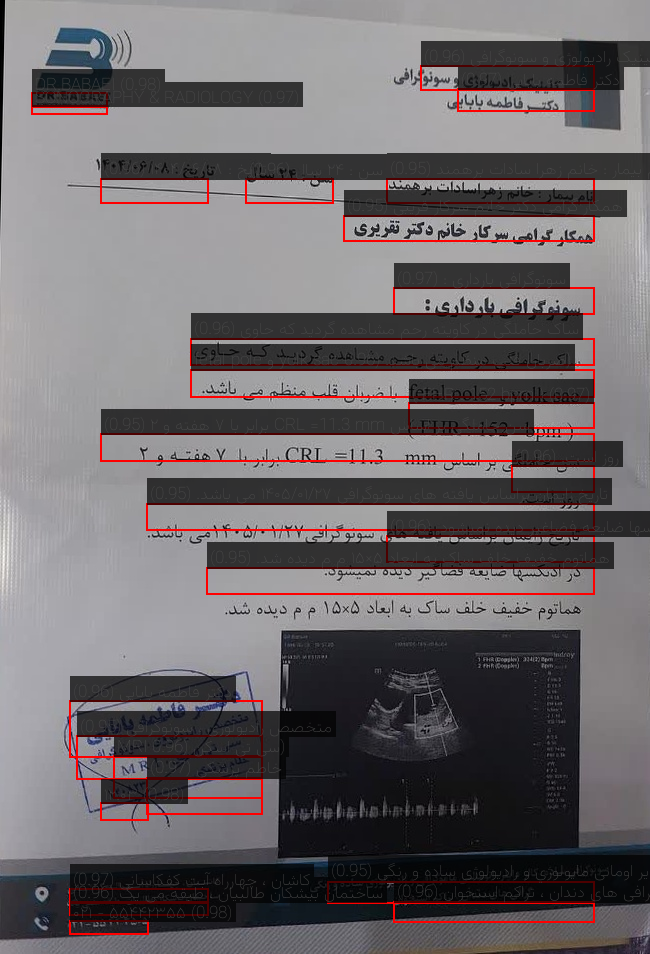

Saved visualization to: extracted_document_vis.jpg


In [10]:
image_path = r"C:/Users/smmeh/Desktop/Project Doc Reader/extracted_document.jpg"
out = visualize_bboxes_notebook(image_path, response, out_path="extracted_document_vis.jpg")
print("Saved visualization to:", out)

In [ ]:
# Get Noto font
# !apt-get install fonts-noto-cjk 

import os
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
from bs4 import BeautifulSoup, Tag
from pathlib import Path
import re

# Function to draw bounding boxes and text on images based on HTML content
def draw_bbox(image_path, resized_width, resized_height, full_predict):
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    original_width = image.width
    original_height = image.height
    
    # Parse the provided HTML content
    soup = BeautifulSoup(full_predict, 'html.parser')
    # Extract all elements that have a 'data-bbox' attribute
    elements_with_bbox = soup.find_all(attrs={'data-bbox': True})

    filtered_elements = []
    for el in elements_with_bbox:
        if el.name == 'ol':
            continue  # Skip <ol> tags
        elif el.name == 'li' and el.parent.name == 'ol':
            filtered_elements.append(el)  # Include <li> tags within <ol>
        else:
            filtered_elements.append(el)  # Include all other elements

    font = ImageFont.truetype(r"C:\Windows\Fonts\arial.ttf", 20)
    draw = ImageDraw.Draw(image)
    
    # Draw bounding boxes and text for each element
    for element in filtered_elements:
        bbox_str = element['data-bbox']
        text = element.get_text(strip=True)
        x1, y1, x2, y2 = map(int, bbox_str.split())
        
        # Calculate scaling factors
        scale_x = resized_width / original_width
        scale_y = resized_height / original_height
        
        # Scale coordinates accordingly
        x1_resized = int(x1 / scale_x)
        y1_resized = int(y1 / scale_y)
        x2_resized = int(x2 / scale_x)
        y2_resized = int(y2 / scale_y)
        
        if x1_resized > x2_resized:
            x1_resized, x2_resized = x2_resized, x1_resized
        if y1_resized > y2_resized:
            y1_resized, y2_resized = y2_resized, y1_resized
            
        # Draw bounding box
        draw.rectangle([x1_resized, y1_resized, x2_resized, y2_resized], outline='red', width=2)
        # Draw associated text
        draw.text((x1_resized, y2_resized), text, fill='black', font=font)

    # Display the image
    image.show()

# Function to clean and format HTML content
def clean_and_format_html(full_predict):
    soup = BeautifulSoup(full_predict, 'html.parser')
    
    # Regular expression pattern to match 'color' styles in style attributes
    color_pattern = re.compile(r'\bcolor:[^;]+;?')

    # Find all tags with style attributes and remove 'color' styles
    for tag in soup.find_all(style=True):
        original_style = tag.get('style', '')
        new_style = color_pattern.sub('', original_style)
        if not new_style.strip():
            del tag['style']
        else:
            new_style = new_style.rstrip(';')
            tag['style'] = new_style
            
    # Remove 'data-bbox' and 'data-polygon' attributes from all tags
    for attr in ["data-bbox", "data-polygon"]:
        for tag in soup.find_all(attrs={attr: True}):
            del tag[attr]

    classes_to_update = ['formula.machine_printed', 'formula.handwritten']
    # Update specific class names in div tags
    for tag in soup.find_all(class_=True):
        if isinstance(tag, Tag) and 'class' in tag.attrs:
            new_classes = [cls if cls not in classes_to_update else 'formula' for cls in tag.get('class', [])]
            tag['class'] = list(dict.fromkeys(new_classes))  # Deduplicate and update class names

    # Clear contents of divs with specific class names and rename their classes
    for div in soup.find_all('div', class_='image caption'):
        div.clear()
        div['class'] = ['image']

    classes_to_clean = ['music sheet', 'chemical formula', 'chart']
    # Clear contents and remove 'format' attributes of tags with specific class names
    for class_name in classes_to_clean:
        for tag in soup.find_all(class_=class_name):
            if isinstance(tag, Tag):
                tag.clear()
                if 'format' in tag.attrs:
                    del tag['format']

    # Manually build the output string
    output = []
    for child in soup.body.children:
        if isinstance(child, Tag):
            output.append(str(child))
            output.append('\n')  # Add newline after each top-level element
        elif isinstance(child, str) and not child.strip():
            continue  # Ignore whitespace text nodes
    complete_html = f"""```html\n<html><body>\n{" ".join(output)}</body></html>\n```"""
    return complete_html

In [ ]:
from openai import OpenAI
import os
import base64
#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# @title inference function with API
def inference_with_api(image_path, prompt, sys_prompt="You are a helpful assistant."):
    base64_image = encode_image(image_path)
    client = OpenAI(
      base_url="https://openrouter.ai/api/v1",
      api_key="....",
    )
    base64_image = encode_image(image_path)
    completion = client.chat.completions.create(
      extra_headers={
        "HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
        "X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
      },
      extra_body={},
      model="qwen/qwen3-vl-235b-a22b-instruct",
      messages=[
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            },
            {
              "type": "image_url",
              "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            }
          ]
        }
      ]
    )
    return completion.choices[0].message.content

In [ ]:
img_url = "C:/Users/smmeh/Desktop/Project Doc Reader/example.jpg"
image = Image.open(img_url)

system_prompt="You are an AI specialized in recognizing and extracting text from images. Your mission is to analyze the image document and generate the result in QwenVL Document Parser HTML format using specified tags while maintaining user privacy and data integrity."
prompt =  "QwenVL HTML "

# ## Use a local HuggingFace model to inference.
# output, input_height, input_width = inference(img_url, prompt)




# Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
from qwen_vl_utils import smart_resize
#os.environ['DASHSCOPE_API_KEY'] = "'your_api_key_here'"
# min_pixels = 512*28*28
# max_pixels = 2048*28*28
image = Image.open(img_url)
#width, height = image.size
#input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels,factor=28)
output = inference_with_api(img_url, prompt)


# Visualization
# print(input_height, input_width)
print(output)
# draw_bbox(img_url, input_width, input_height, output)

ordinary_html = clean_and_format_html(output)
print(ordinary_html)